In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import os; print(os.getcwd())
import socket; print(socket.gethostname())
from glob import glob
import json

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 150
from IPython.display import display
from ipywidgets import widgets

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/home/aljubetic/AF2/projects/2023-03-14__mALB8_all_by_all
headnode


In [6]:
df = pd.read_csv('data/AF2_rosetta_merged.csv.gz', index_col=0)




#Add a 0 so that ids are correctly sorted
df['id1'].replace(r'P(\d)$', r'P0\1', inplace=True, regex=True)
df['id2'].replace(r'P(\d)$', r'P0\1', inplace=True, regex=True)
print(list(df.columns))

df.rename(columns={"rosetta-protocol": "rosetta_protocol"}, inplace=True)
df.head(5)

['full_name_path', 'stem_name', 'dir', 'base_name', 'id1', 'id2', 'rank', 'model_number', 'plddt', 'max_pae', 'pae', 'ptm', 'iptm', 'msa_mode', 'msa_depth', 'model_type', 'num_recycles', 'decoy', 'IA_complex_normalized', 'IA_dG_cross', 'IA_dG_cross/dSASAx100', 'IA_dG_separated', 'IA_dG_separated/dSASAx100', 'IA_dSASA_hphobic', 'IA_dSASA_int', 'IA_dSASA_polar', 'IA_delta_unsatHbonds', 'IA_hbond_E_fraction', 'IA_hbonds_int', 'IA_nres_all', 'IA_nres_int', 'IA_packstat', 'IA_per_residue_energy_int', 'IA_sc_value', 'IA_side1_normalized', 'IA_side1_score', 'IA_side2_normalized', 'IA_side2_score', 'cart_bonded', 'cms', 'cms_apolar', 'cms_sq5', 'complex_normalized', 'dG_cross', 'dG_cross/dSASAx100', 'dG_separated', 'dG_separated/dSASAx100', 'dSASA_hphobic', 'dSASA_int', 'dSASA_polar', 'ddg', 'delta_unsatHbonds', 'dslf_fa13', 'exposed_hydrop', 'fa_atr', 'fa_dun_dev', 'fa_dun_rot', 'fa_dun_semi', 'fa_elec', 'fa_intra_atr_xover4', 'fa_intra_elec', 'fa_intra_rep_xover4', 'fa_intra_sol_xover4', 'fa

In [7]:
df['mean_plddt'] = df['plddt']
df['mean_pae_interaction'] = df['pae']
df['model_number'] = df['model_number'].apply(str)

alphafold2_multimer_v3
1 0
1001__mALb8x1_fdrtc_B 1001__mALb8x1_fdrtc_A
load out/01__multimer-v3/rosetta-min-sc/1001__mALb8x1_fdrtc_B__1001__mALb8x1_fdrtc_A_relaxed_rank_001_alphafold2_multimer_v3_model_4_seed_000__rrelaxed/1001__mALb8x1_fdrtc_B__1001__mALb8x1_fdrtc_A_relaxed_rank_001_alphafold2_multimer_v3_model_4_seed_000__rrelaxed_0001.pdb
load out/01__multimer-v3/rosetta-min-sc/1001__mALb8x1_fdrtc_B__1001__mALb8x1_fdrtc_A_relaxed_rank_002_alphafold2_multimer_v3_model_2_seed_000__rrelaxed/1001__mALb8x1_fdrtc_B__1001__mALb8x1_fdrtc_A_relaxed_rank_002_alphafold2_multimer_v3_model_2_seed_000__rrelaxed_0001.pdb
load out/01__multimer-v3/rosetta-min-sc/1001__mALb8x1_fdrtc_B__1001__mALb8x1_fdrtc_A_relaxed_rank_004_alphafold2_multimer_v3_model_3_seed_000__rrelaxed/1001__mALb8x1_fdrtc_B__1001__mALb8x1_fdrtc_A_relaxed_rank_004_alphafold2_multimer_v3_model_3_seed_000__rrelaxed_0001.pdb
load out/01__multimer-v3/rosetta-min-sc/1001__mALb8x1_fdrtc_B__1001__mALb8x1_fdrtc_A_relaxed_rank_003_alphafol

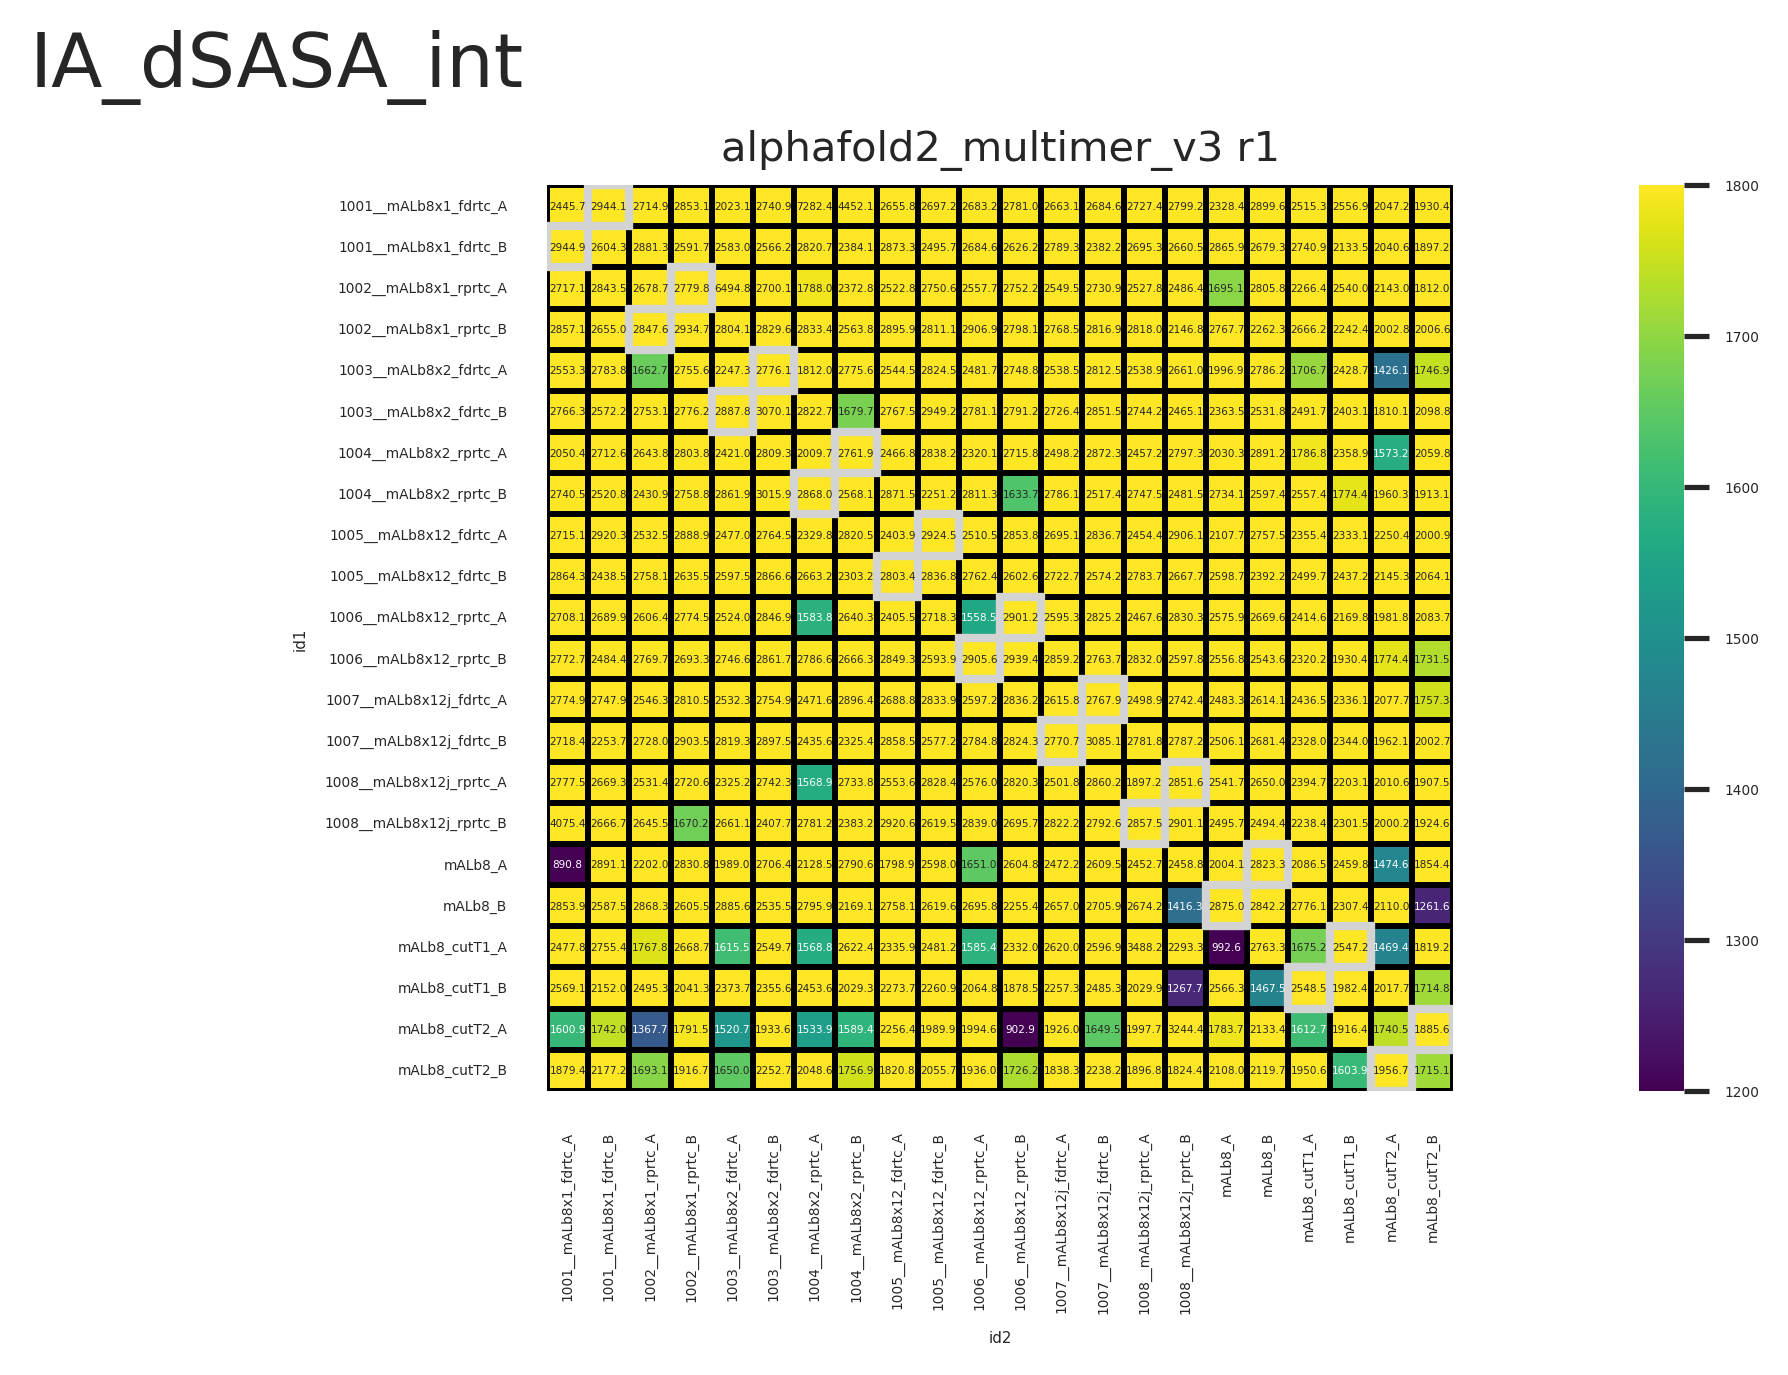

In [26]:
ranges_by_field = dict(
    mean_plddt = (75,100),
    IA_dSASA_int = (1200, 1800),
)
def plot(df, model_type, model_number, msa_depth, rosetta_protocol, field, pdb, reverse_color_scale=False, annotate=False, auto_range=False):
    
    print(model_type)
    if str(model_number).isnumeric():
        qstr = f'model_type=="{model_type}" and model_number=="{model_number}" and msa_depth=={msa_depth} and rosetta_protocol=="{rosetta_protocol}"'
        print(qstr)
        mat = df.query(qstr)
        
    elif len(model_number)==2:
        #Take care of rank 
        rank = int(model_number[1]) 
        mat = df.query(f'model_type=="{model_type}" and msa_depth=={msa_depth} and rank=={rank} and rosetta_protocol=="{rosetta_protocol}"')  
    else:


        df = df.query(f'model_type=="{model_type}" and msa_depth=={msa_depth}')
        mat = df.groupby('id1 id2'.split())
        
        #calls the mean, min, max function of mat group by
        mat = getattr(mat, model_number)()
        
    N = len(mat)
    df = df.sort_values(by=field, ascending=True)
    pos1 , pos2 = pdb.split()
    pos1 = int(pos1)
    pos2 = int(pos2)
    print(pos1, pos2)    
    
    

    #for path in pdb_filt.full_name.values:
    #    print(f'load {path}')

    mat = mat.pivot_table(values=field, index='id1', columns='id2')
    #return mat
    id1 = mat.columns[pos1]
    id2 = mat.index[pos2]
    print(id1, id2)

    pdb_info = df.query(f"id1=='{id1}' and id2=='{id2}' and rosetta_protocol=='{rosetta_protocol}'")
    for pdb in pdb_info.full_name:
        print(f'load {pdb}')
    if field in ranges_by_field and not auto_range:
        vmin, vmax = ranges_by_field[field]
    else:
        vmin, vmax = None, None
    
    if reverse_color_scale:
        cmap ='viridis_r'
    else:
        cmap='viridis'
   
    f, ax = plt.subplots(figsize=(16, 4), dpi=300 )
    mpl.rcParams.update({'font.size': 3})
    sns.set(font_scale = 0.3)
    sns.heatmap(mat, cmap=cmap, linewidths=1, linecolor='black', annot=annotate, annot_kws={"size": 2.5}, fmt=".1f", vmin=vmin, vmax=vmax, xticklabels=True, yticklabels=True, ax=ax)
    plt.suptitle(field, y=1.01, fontsize=18)
    plt.title(f'{model_type} {model_number}', fontsize=10)
    
    ax = plt.gca()
    for i in range(0, N+1, 2): 
        ax.add_patch( plt.Rectangle((i, i+1), 1, 1, fill=False, edgecolor='lightgray', lw=2) )
        ax.add_patch( plt.Rectangle((i+1, i), 1, 1, fill=False, edgecolor='lightgray', lw=2) )
    #return df
    ax.set_aspect('equal','box')
    

#sns.set_context("talk")

mat = plot(df, 'alphafold2_multimer_v3', model_number='r1', msa_depth=2, rosetta_protocol='rosetta-min-sc', field='IA_dSASA_int', pdb='1 0', annotate=True)

In [29]:
ranges_by_field = dict(
    mean_plddt = (75,100),
    IA_dSASA_int = (1200, 1800),
    IA_dSASA_polar = (350, 600)
)


from ipywidgets import interact, fixed


interact(plot, df=fixed(df), model_type=['alphafold2_multimer_v3','monomer_ptm','multimer', 'multimer_v2'], 
model_number='1 2 3 4 5 min max mean median std r1 r2 r3 r4 r5'.split(),
msa_depth=[2, 512], rosetta_protocol="rosetta-min-sc rosetta-flex-bb".split(),
field='mean_plddt mean_pae_interaction pTMscore elapsed_time IA_dG_cross IA_dSASA_int IA_dSASA_polar IA_sc_value IA_delta_unsatHbonds IA_nres_int IA_per_residue_energy_int IA_sc_value ptm iptm msa_depth\
   cms sc2 sc2_int_area sc2_median_dist vbuns sbuns score_per_res timed'.split(),
pdb='0 0', reverse_color_scale=False, annotate=False, auto_range=True)

interactive(children=(Dropdown(description='model_type', options=('alphafold2_multimer_v3', 'monomer_ptm', 'mu…

<function __main__.plot(df, model_type, model_number, msa_depth, rosetta_protocol, field, pdb, reverse_color_scale=False, annotate=False, auto_range=False)>

In [6]:
grid = widgets.GridspecLayout(12, 12)
def on_btn_click(btn):
    print(btn.description)

for i in range(12):
    for j in range(12):
        grid[i, j] = widgets.Button(description="[P%d, P%d]"%(i,j), button_style="primary")

display(grid)

GridspecLayout(children=(Button(button_style='primary', description='[P0, P0]', layout=Layout(grid_area='widge…

In [7]:
%matplotlib inline
from ipywidgets import interactive
import matplotlib.pyplot as plt
import numpy as np

def f(m, b):
    plt.figure(2)
    x = np.linspace(-10, 10, num=1000)
    plt.plot(x, m * x + b)
    plt.ylim(-5, 5)
    plt.show()

interactive_plot = interactive(f, m=(-2.0, 2.0), b=(-3, 3, 0.5))
output = interactive_plot.children[-1]
output.layout.height = '350px'
interactive_plot

interactive(children=(FloatSlider(value=0.0, description='m', max=2.0, min=-2.0), FloatSlider(value=0.0, descr…